# Linear Regression

Analizar el comportamiento del salario de los CEOs.

## Descripción del dataset

El dataset es un censo del salario y diferentes condiciones personales de CEOs de empresas: https://www.cengage.com/cgi-wadsworth/course_products_wp.pl?fid=M20b&product_isbn_issn=9781111531041

El objetivo es producir un modelo de regresión para predecir el salario de un CEO a partir de diferentes variables.

Las variables con la que cuenta el dataset son las siguientes:
- salary: 1990 compensation, $1000s
- age: in years
- college: =1 if attended college
- grad: =1 if attended graduate school
- comten: years with company
- ceoten: years as ceo with company
- sales: 1990 firm sales, millions
- profits: 1990 profits, millions
- mktval: market value, end 1990, mills.

Se pueden generar variables adicionales con transformaciones no lineales de una variable o con la relación de dos de ellas:
- lsalary: log(salary)
- lsales: log(sales)
- lmktval: log(mktval)
- comtensq: comten^2
- ceotensq: ceoten^2
- profmarg: profits as percent of sales

## Objetivo

Generar una regresión lineal para explicar el salario de los CEOs


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools

from pandas.api.types import is_numeric_dtype
from matplotlib.ticker import PercentFormatter


import sklearn, statsmodels
import statsmodels.api as sm
from statsmodels.tools.tools import pinv_extended

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse_score
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline, make_union
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge

## Preparación de los datos

- Se muestra una previsualización del las primeras filas del dataset
- Se arreglan problemas de lectura del csv y se toman los logaritmos correctamente
- Se realiza una descripción estadística de las columnas numéricas del dataset

In [2]:
df = pd.read_csv('./datasets/ceosal.csv',sep=';')

In [3]:
print(f'Shape del dataset {df.shape}')

Shape del dataset (177, 14)


In [4]:
df.head()

,salary,age,college,grad,comten,ceoten,sales,profits,mktval,lsalary,lsales,lmktval,comtensq,ceotensq
0,1161,49,1,1,9,2,6200,966,23200,70.570.369,87.323.046,10.051.908,81,4
1,600,43,1,1,10,10,283,48,1100,63.969.297,56.454.468,70.030.656,100,100
2,379,51,1,1,9,3,169,40,1100,59.375.362,51.298.985,70.030.656,81,9
3,651,55,1,0,22,22,1100,-54,1000,64.785.094,70.030.656,69.077.554,484,484
4,497,44,1,1,8,6,351,28,387,620.859,58.607.864,59.584.246,64,36


In [5]:
# Fix log columns
df['lsalary'] = np.log(df['salary'])
df['lsales'] = np.log(df['sales'])
df['lmktval'] = np.log(df['mktval'])

# Add profit margin
df['profmarg'] = df.profits/df.sales*100

In [6]:
df.head()

,salary,age,college,grad,comten,ceoten,sales,profits,mktval,lsalary,lsales,lmktval,comtensq,ceotensq,profmarg
0,1161,49,1,1,9,2,6200,966,23200,7.057037,8.732305,10.051908,81,4,15.580645
1,600,43,1,1,10,10,283,48,1100,6.396930,5.645447,7.003065,100,100,16.961131
2,379,51,1,1,9,3,169,40,1100,5.937536,5.129899,7.003065,81,9,23.668639
3,651,55,1,0,22,22,1100,-54,1000,6.478510,7.003065,6.907755,484,484,-4.909091
4,497,44,1,1,8,6,351,28,387,6.208590,5.860786,5.958425,64,36,7.977208


In [7]:
df.describe()

,salary,age,college,grad,comten,ceoten,sales,profits,mktval,lsalary,lsales,lmktval,comtensq,ceotensq,profmarg
count,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000
mean,865.864407,56.429379,0.971751,0.531073,22.502825,7.954802,3529.463277,207.830508,3600.316384,6.582848,7.231025,7.399410,656.683616,114.124294,6.420110
std,587.589281,8.421890,0.166152,0.500449,12.294735,7.150826,6088.654193,404.454296,6442.276020,0.606059,1.432086,1.133414,577.122655,212.565996,17.860744
min,100.000000,33.000000,0.000000,0.000000,2.000000,0.000000,29.000000,-463.000000,387.000000,4.605170,3.367296,5.958425,4.000000,0.000000,-203.076923
25%,471.000000,52.000000,1.000000,0.000000,12.000000,3.000000,561.000000,34.000000,644.000000,6.154858,6.329721,6.467699,144.000000,9.000000,4.230769
50%,707.000000,57.000000,1.000000,1.000000,23.000000,6.000000,1400.000000,63.000000,1200.000000,6.561031,7.244228,7.090077,529.000000,36.000000,6.833713
75%,1119.000000,62.000000,1.000000,1.000000,33.000000,11.000000,3500.000000,208.000000,3500.000000,7.020191,8.160518,8.160518,1089.000000,121.000000,10.947368
max,5299.000000,86.000000,1.000000,1.000000,58.000000,37.000000,51300.000000,2700.000000,45400.000000,8.575273,10.845446,10.723267,3364.000000,1369.000000,47.457627


#### Analisis de nulos

- Se puede ver que no hay columnas con registros nulos.

In [8]:
df.isna().mean()

salary      0.0
age         0.0
college     0.0
grad        0.0
comten      0.0
ceoten      0.0
sales       0.0
profits     0.0
mktval      0.0
lsalary     0.0
lsales      0.0
lmktval     0.0
comtensq    0.0
ceotensq    0.0
profmarg    0.0
dtype: float64

#### Remover Outliers

Para quitar outliers se utilizó el criterio del rango medio intercuartil (IQR), donde se calcula que los outliers son aquellas observaciones menores a $1.5*Q_1$ y mayores a $1.5*Q_3$, donde $Q_1$ es el valor de la variable por debajo del que se encuentran el 25\% de las observaciones y $Q_3$ es el valor de la variable por debajo del que se encuentras el 75\% de las observaciones (también son llamados $Q_{25\%}$ y $Q_{75\%}$. 
Se realizaron los histogramas y boxplots de las variables cuantitativas lineales del dataset y para las variables cualitativas (college y grad, representadas con un booleano) y se obtiveron las siguientes conclusiones.
- Para la variable _age_ se encuentran 3 outliers, fuera del IQC de 38 a 77 años, representando el 3.39\% de los datos, se pueden quitar estos outliers ya que el porcentaje de datos es bajo y se puede estimar que no habrá un impacto importante en el análisis final.
- Con respecto a las variables _college_ y _grad_, pueden ser consideradas distribuciones de Bernoulli, por lo que no se puede tomar el criterio de IQR para remover outliers.
- Para las variables _salary_, _ceoten_, _sales_ y _profits_, si bien existen outliers con este criterio, su comportamiento no es el de una variable con una distribición normal o gausseana, por lo que utilizar este criterio para quitar los outliers sería erroneo: se realizará el análisis sin quitarlos.
- Para la variable _comten_, si bien tampoco sigue una distribución normal, no se encuentran outliers con el metodo de IQR.
- La variable _profmarg_ muestra una tendencia a tener una mediana muy fuerte, como el porcentaje de outliers es relativamente bajo (~5\%) se procede a quitar estos outliers
- Se puede estimar la distribución de las variables que no se ajustan a una distribución normal, se debería hacer pruebas de bondad de ajuste que escapan al alcance de este análisis (https://www.datasciencecentral.com/common-probability-distributions-the-data-scientist-s-crib-sheet/): 
    - La variables _salary_, _ceoten_ y _sales_ parecerian tener una distribución exponencial
    - La variable _comten_ parecería tener una distribución uniforme
    - La variable _profits_ parecería tener una distribución chi-squared
    - La varibable _profmarg_ parecería tener una distribución normal leptokurtica, pero hay muy pocos datos para afirmarlo


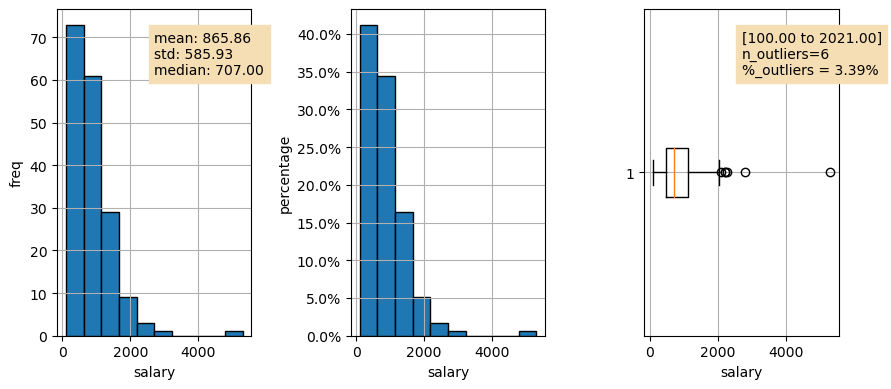

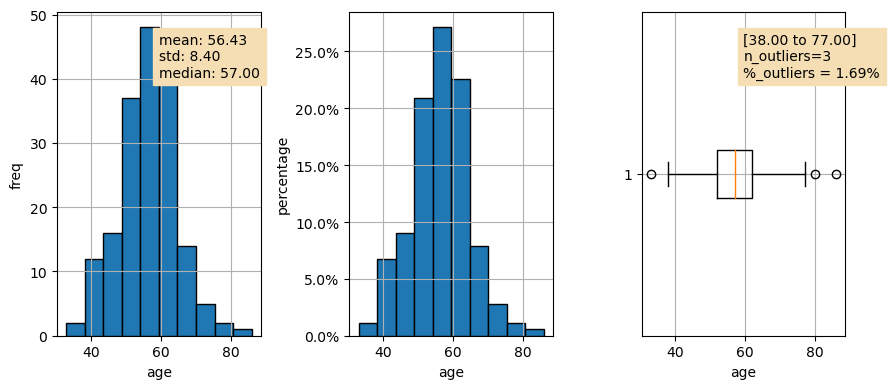

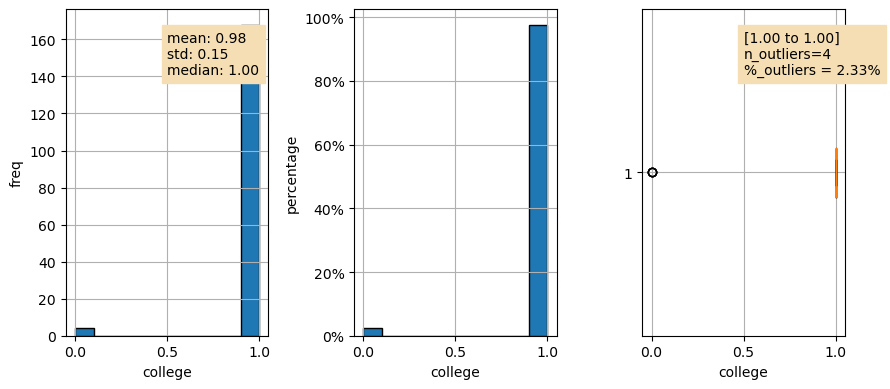

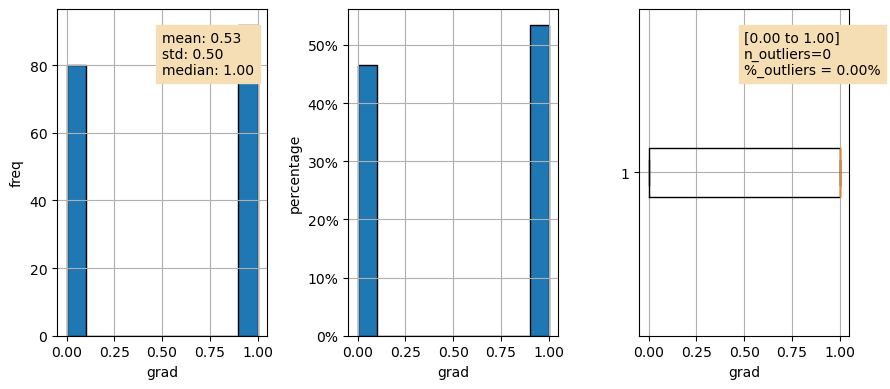

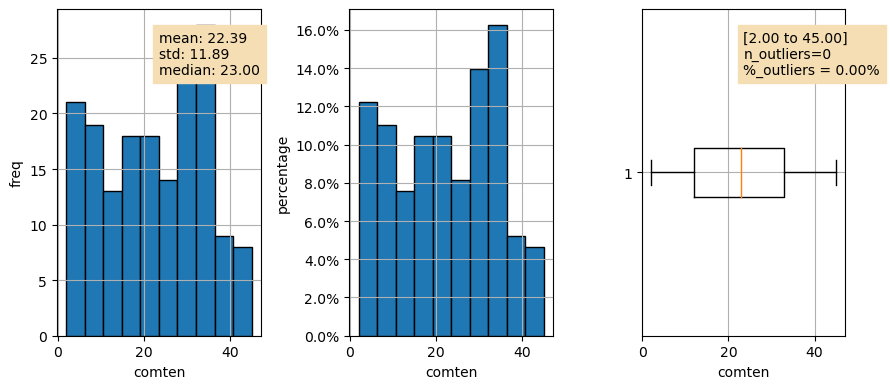

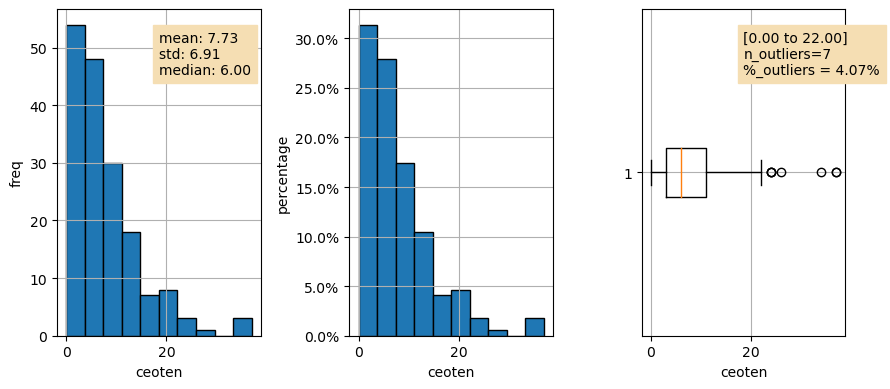

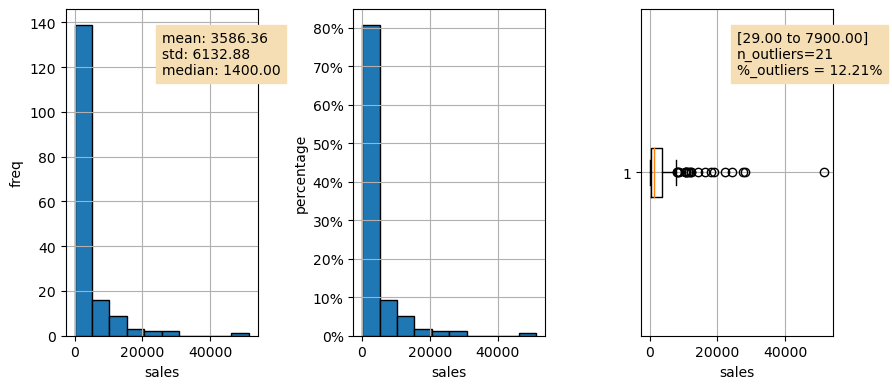

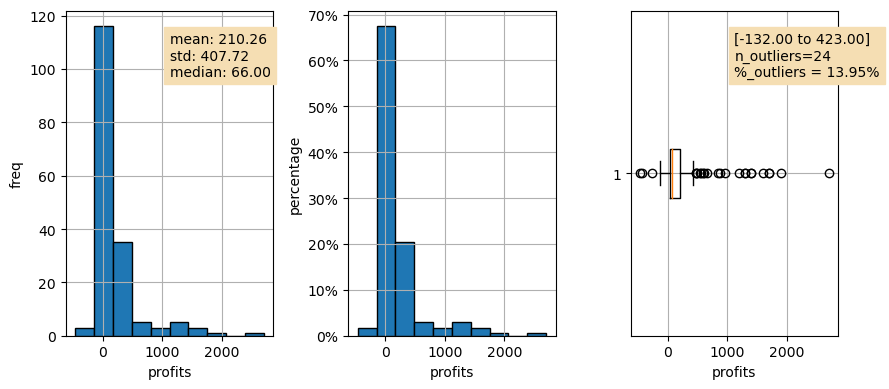

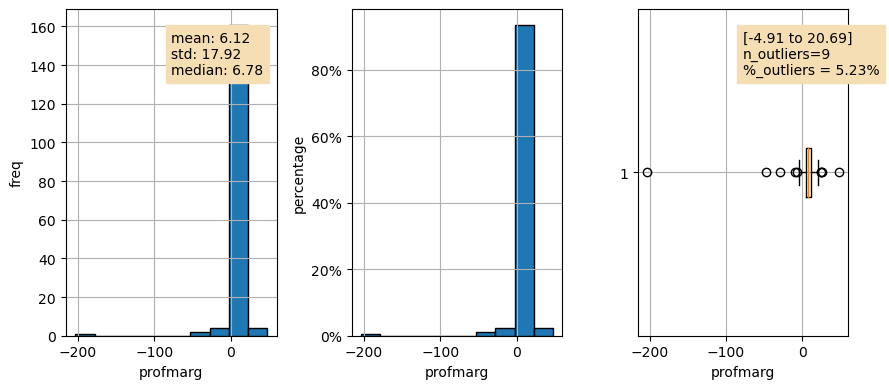

In [9]:
cols_to_analyse = ['salary', 'age', 'college', 'grad', 'comten', 'ceoten', 'sales','profits','profmarg']
cols_to_remove_outliers = ['age','profmarg']

for col in cols_to_analyse:
    fig, axes = plt.subplots(1,3,figsize=(9,4),tight_layout=True)
    ax = axes[0]
    ax.set_xlabel(col)
    ax.hist(df[col],edgecolor='black')
    ax.set_xlabel(col)
    ax.set_ylabel('freq')
    ax.annotate(text= '\n'.join((
                       f'mean: {np.mean(df[col]):.2f}',
                       f'std: {np.std(df[col]):.2f}',
                       f'median: {np.median(df[col]):.2f}',
                       )),
                xy=(0.5,0.8),
                xycoords='axes fraction',
                backgroundcolor='wheat'
                )
    ax.grid(True)
    
    ax = axes[1]
    ax.set_xlabel(col)
    ax.hist(df[col], weights=np.ones(len(df)) / len(df),edgecolor='black')
    ax.set_xlabel(col)
    ax.set_ylabel('percentage')
    ax.grid(True)
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    
    
    ax = axes[2]
    box = ax.boxplot(df[col],vert=False)
    lw = box['whiskers'][0].get_xdata()[1] # High whisker
    hw = box['whiskers'][1].get_xdata()[1] # Low whisker
    n_out = len(df[(df[col] < lw) | (df[col] > hw) ])
    ax.annotate(text= '\n'.join((
                       f'[{lw:.2f} to {hw:.2f}]',
                       f'n_outliers={n_out}',
                       f'%_outliers = {(n_out/len(df[col]))*100:.2f}%'
                       )),
                xy=(0.5,0.8),
                xycoords='axes fraction',
                backgroundcolor='wheat')
    ax.set_xlabel(col)
    ax.grid(True)

    # Remove outliers based on conclutions
    if(col in cols_to_remove_outliers):
        df = df[(df[col] > lw) & (df[col] < hw)]

In [10]:
print(f'Shape del dataset {df.shape}')

Shape del dataset (161, 15)


## EDA

#### Matriz de correlación de Pearson
- Observando la matriz de correlación de Pearson se busca las variables con valores de coeficiente de Pearson alto (valor absoluto cercano a 1).
- La correlación más alta de la matriz es entre el _mktval_ y las _sales_ una relación esperable. Su relación _profmarg_ podría usarse como una métrica directa del salario, sin embargo, se ve que hay una correlación muy pequeña entre _profmarg_ y _salary_, e incluso negativa, un resultado no esperable.
- Se puede ver que el valor de correlación de _salary_ más alto se encuentra en una relación trivial, que es entre _salary_ y su logaritmo natural, estas relaciones no son explicativas, ya que son una transformación de la misma variable. Sucede un caso similar de alta correlación con _ceoten_ y _ceotensq_ o _comten_ y _comtensq_, que son una misma variable con una transformación no lineal de sí misma.
- Los demás valores de correlación más altos para _salary_ son _sales_ y _mktval_, teniendo una correlación levemente mayor con las transformaciones logarítmicas de estas variables, indicando que debería existir un ajuste levemente superior a una relación lineal. Tomar el logaritmo natural de la variable indica que cada incremento de $e$ veces en la variable lineal implica un incremento unitario en la variable logarítmica. Por lo tanto, se podría decir que hay una moderada correlación entre el incremento del salario e incrementos de $e$ veces de _sales_ y _mktval_
- Se puede observar además que hay una muy baja correlación entre el logaritmo natural del salario y las demás variables, y las correlaciones altas son las mismas que las que existen con el salario como variable lineal, por lo que en este trabajo se utilizará el salario lineal como variable dependiente de las demás

<Axes: >

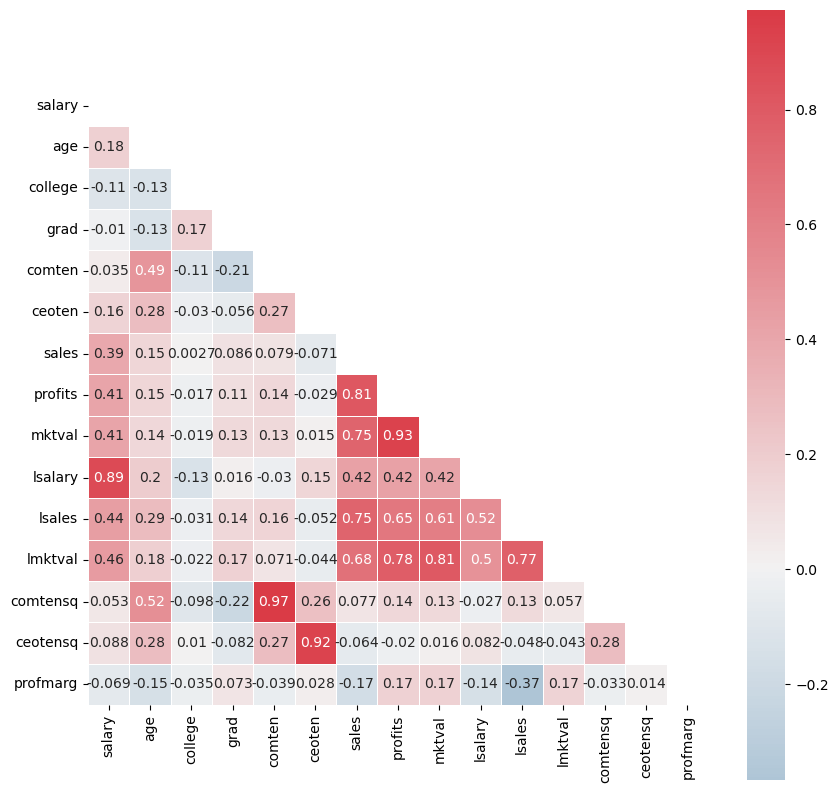

In [11]:
# Pearson Correlation
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(df.corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, annot=True)

- Se muestra la relación del salario con variables que tienen poca correlación en la matriz. Para empezar con variable _age_, tanto el salario como el logaritmo natural del salario tienen un coeficiente de determinación $R^2$ sumamente bajo si se realiza una regresión lineal con respecto a la edad. Si bien el Mean Squared Error (MSE) es sustancialmente menor para el caso del logaritmo del salario, esto se explica debido a la menor dispersión de los datos propia de la transformación no lineal
- Para la variable _profit_ y _profmarg_ se puede llegar a una conclusión similar, donde el coeficiente de determinación es levemente superior para la primera, pero la dispersión de los datos es demasiado grande para afirmar que una regresión lineal es suficientemente explicativa de algún tipo de tendencia

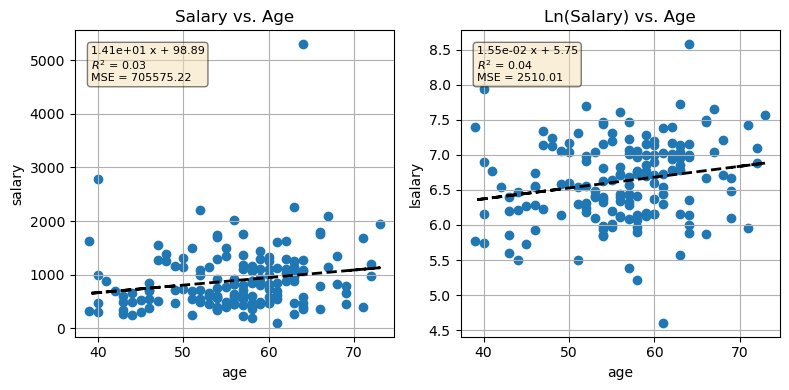

In [12]:
fig, axes = plt.subplots(1,2,figsize=(8,4),tight_layout=True)

ax = axes[0]
ax.set_title('Salary vs. Age')
x = df[['age']]
y = df.salary
reg = LinearRegression().fit(x,y)
ax.set_ylabel('salary')
ax.set_xlabel('age')
ax.scatter(x,y)
ax.plot(x,reg.predict(x),color='black',linestyle='--',linewidth=2)
textstr = '\n'.join((
    f'{reg.coef_[0]:.2e} x + {reg.intercept_:.2f}',
    f'$R^2$ = {reg.score(x, y):.2f}',
    f'MSE = {mse_score(x,reg.predict(x)):.2f}'
    ))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
ax.grid(True)

ax = axes[1]
ax.set_title('Ln(Salary) vs. Age')
x = df[['age']]
y = df.lsalary
reg = LinearRegression().fit(x,y)
ax.set_ylabel('lsalary')
ax.set_xlabel('age')
ax.scatter(x,y)
ax.plot(x,reg.predict(x),color='black',linestyle='--',linewidth=2)
textstr = '\n'.join((
    f'{reg.coef_[0]:.2e} x + {reg.intercept_:.2f}',
    f'$R^2$ = {reg.score(x, y):.2f}',
    f'MSE = {mse_score(x,reg.predict(x)):.2f}'
    ))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
ax.grid(True)

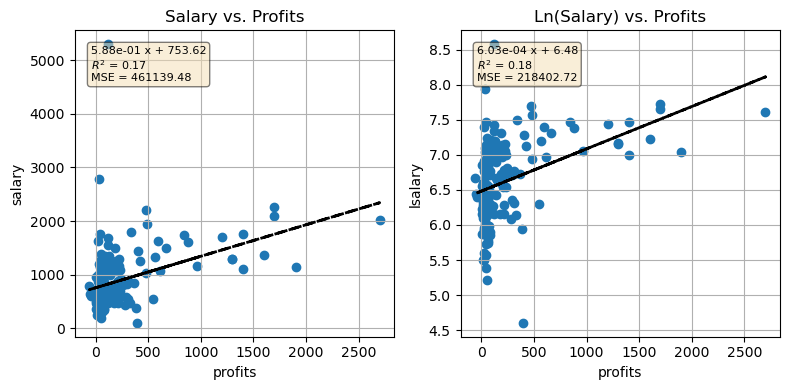

In [13]:
fig, axes = plt.subplots(1,2,figsize=(8,4),tight_layout=True)

ax = axes[0]
ax.set_title('Salary vs. Profits')
x = df[['profits']]
y = df.salary
reg = LinearRegression().fit(x,y)
ax.set_ylabel('salary')
ax.set_xlabel('profits')
ax.scatter(x,y)
ax.plot(x,reg.predict(x),color='black',linestyle='--',linewidth=2)
textstr = '\n'.join((
    f'{reg.coef_[0]:.2e} x + {reg.intercept_:.2f}',
    f'$R^2$ = {reg.score(x, y):.2f}',
    f'MSE = {mse_score(x,reg.predict(x)):.2f}'
    ))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
ax.grid(True)

ax = axes[1]
ax.set_title('Ln(Salary) vs. Profits')
x = df[['profits']]
y = df.lsalary
reg = LinearRegression().fit(x,y)
ax.set_ylabel('lsalary')
ax.set_xlabel('profits')
ax.scatter(x,y)
ax.plot(x,reg.predict(x),color='black',linestyle='--',linewidth=2)
textstr = '\n'.join((
    f'{reg.coef_[0]:.2e} x + {reg.intercept_:.2f}',
    f'$R^2$ = {reg.score(x, y):.2f}',
    f'MSE = {mse_score(x,reg.predict(x)):.2f}'
    ))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
ax.grid(True)

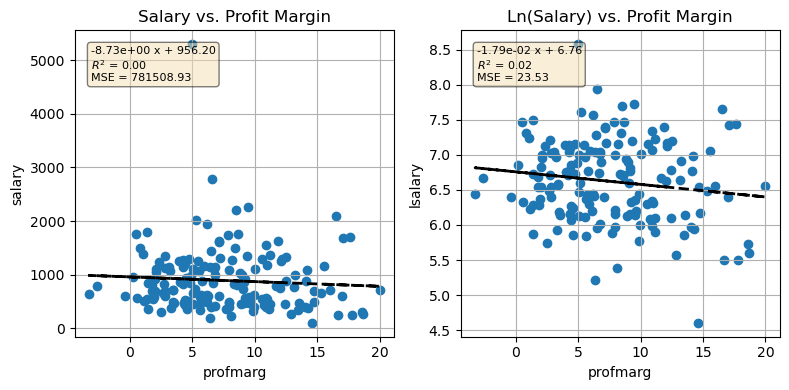

In [14]:
fig, axes = plt.subplots(1,2,figsize=(8,4),tight_layout=True)

ax = axes[0]
ax.set_title('Salary vs. Profit Margin')
x = df[['profmarg']]
y = df.salary
reg = LinearRegression().fit(x,y)
ax.set_ylabel('salary')
ax.set_xlabel('profmarg')
ax.scatter(x,y)
ax.plot(x,reg.predict(x),color='black',linestyle='--',linewidth=2)
textstr = '\n'.join((
    f'{reg.coef_[0]:.2e} x + {reg.intercept_:.2f}',
    f'$R^2$ = {reg.score(x, y):.2f}',
    f'MSE = {mse_score(x,reg.predict(x)):.2f}'
    ))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
ax.grid(True)

ax = axes[1]
ax.set_title('Ln(Salary) vs. Profit Margin')
x = df[['profmarg']]
y = df.lsalary
reg = LinearRegression().fit(x,y)
ax.set_ylabel('lsalary')
ax.set_xlabel('profmarg')
ax.scatter(x,y)
ax.plot(x,reg.predict(x),color='black',linestyle='--',linewidth=2)
textstr = '\n'.join((
    f'{reg.coef_[0]:.2e} x + {reg.intercept_:.2f}',
    f'$R^2$ = {reg.score(x, y):.2f}',
    f'MSE = {mse_score(x,reg.predict(x)):.2f}'
    ))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
ax.grid(True)

- Con respecto a la variable _sales_ se puede ver que un modelo de regresión lineal es bastante representativo si se toma el salario lineal con respecto al logaritmo natural de las ventas, con un coeficiente $R^2 = 0.2$. El MSE cambia significativamente si se toma el logaritmo natural del salario o el salario lineal debido a los valores absolutos de esta variable.

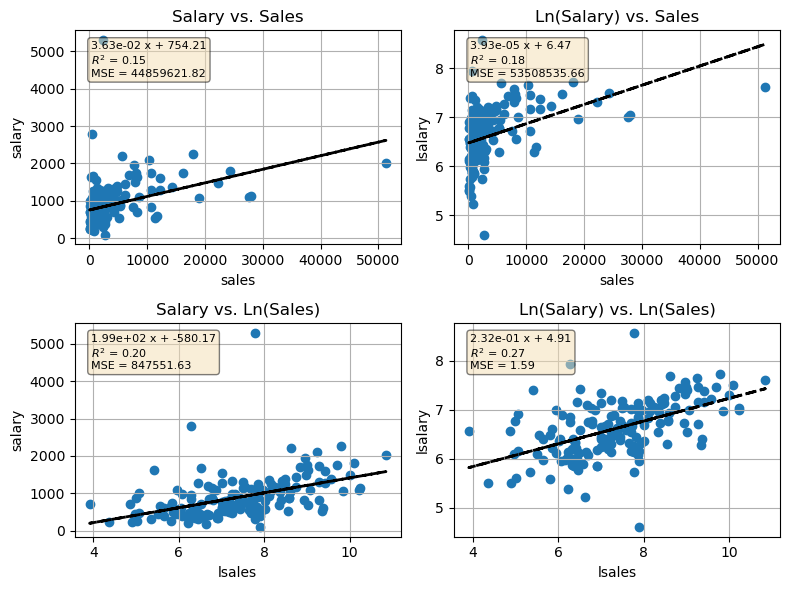

In [15]:
fig, axes = plt.subplots(2,2,figsize=(8,6),tight_layout=True)

ax = axes[0][0]
ax.set_title('Salary vs. Sales')
x = df[['sales']]
y = df.salary
reg = LinearRegression().fit(x,y)
ax.set_ylabel('salary')
ax.set_xlabel('sales')
ax.scatter(x,y)
ax.plot(x,reg.predict(x),color='black',linestyle='--',linewidth=2)
textstr = '\n'.join((
    f'{reg.coef_[0]:.2e} x + {reg.intercept_:.2f}',
    f'$R^2$ = {reg.score(x, y):.2f}',
    f'MSE = {mse_score(x,reg.predict(x)):.2f}'
    ))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
ax.grid(True)

ax = axes[0][1]
ax.set_title('Ln(Salary) vs. Sales')
x = df[['sales']]
y = df.lsalary
reg = LinearRegression().fit(x,y)
ax.set_ylabel('lsalary')
ax.set_xlabel('sales')
ax.scatter(x,y)
ax.plot(x,reg.predict(x),color='black',linestyle='--',linewidth=2)
textstr = '\n'.join((
    f'{reg.coef_[0]:.2e} x + {reg.intercept_:.2f}',
    f'$R^2$ = {reg.score(x, y):.2f}',
    f'MSE = {mse_score(x,reg.predict(x)):.2f}'
    ))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
ax.grid(True)

ax = axes[1][0]
ax.set_title('Salary vs. Ln(Sales)')
x = df[['lsales']]
y = df.salary
reg = LinearRegression().fit(x,y)
ax.set_ylabel('salary')
ax.set_xlabel('lsales')
ax.scatter(x,y)
ax.plot(x,reg.predict(x),color='black',linestyle='--',linewidth=2)
textstr = '\n'.join((
    f'{reg.coef_[0]:.2e} x + {reg.intercept_:.2f}',
    f'$R^2$ = {reg.score(x, y):.2f}',
    f'MSE = {mse_score(x,reg.predict(x)):.2f}'
    ))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
ax.grid(True)

ax = axes[1][1]
ax.set_title('Ln(Salary) vs. Ln(Sales)')
x = df[['lsales']]
y = df.lsalary
reg = LinearRegression().fit(x,y)
ax.set_ylabel('lsalary')
ax.set_xlabel('lsales')
ax.scatter(x,y)
ax.plot(x,reg.predict(x),color='black',linestyle='--',linewidth=2)
textstr = '\n'.join((
    f'{reg.coef_[0]:.2e} x + {reg.intercept_:.2f}',
    f'$R^2$ = {reg.score(x, y):.2f}',
    f'MSE = {mse_score(x,reg.predict(x)):.2f}'
    ))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
ax.grid(True)

- Con respecto a la variable _mktval_ se puede obtener una conclusión similar que la relación con la variable _sales_, con un coeficiente de determinación muy similar tanto si se toma el salario lineal como el logaritmo del salario.

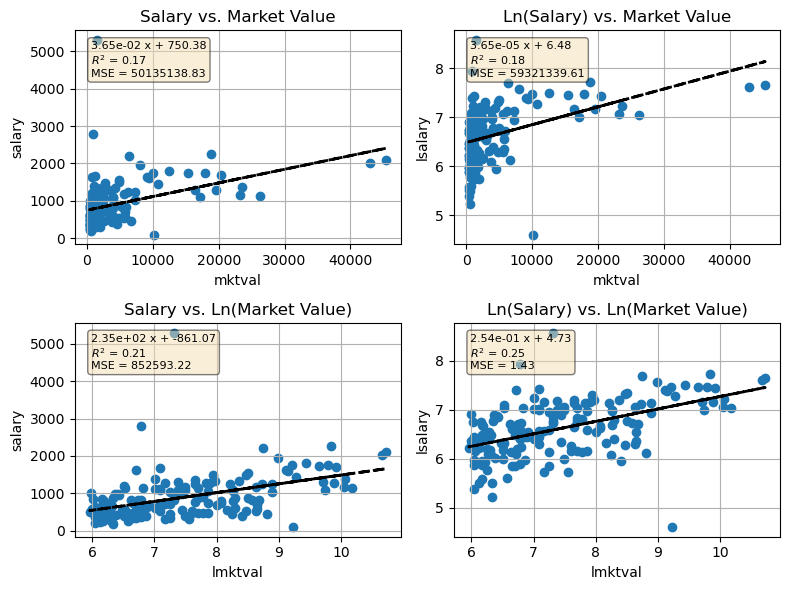

In [16]:
fig, axes = plt.subplots(2,2,figsize=(8,6),tight_layout=True)

ax = axes[0][0]
ax.set_title('Salary vs. Market Value')
x = df[['mktval']]
y = df.salary
reg = LinearRegression().fit(x,y)
ax.set_ylabel('salary')
ax.set_xlabel('mktval')
ax.scatter(x,y)
ax.plot(x,reg.predict(x),color='black',linestyle='--',linewidth=2)
textstr = '\n'.join((
    f'{reg.coef_[0]:.2e} x + {reg.intercept_:.2f}',
    f'$R^2$ = {reg.score(x, y):.2f}',
    f'MSE = {mse_score(x,reg.predict(x)):.2f}'
    ))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
ax.grid(True)

ax = axes[0][1]
ax.set_title('Ln(Salary) vs. Market Value')
x = df[['mktval']]
y = df.lsalary
reg = LinearRegression().fit(x,y)
ax.set_ylabel('lsalary')
ax.set_xlabel('mktval')
ax.scatter(x,y)
ax.plot(x,reg.predict(x),color='black',linestyle='--',linewidth=2)
textstr = '\n'.join((
    f'{reg.coef_[0]:.2e} x + {reg.intercept_:.2f}',
    f'$R^2$ = {reg.score(x, y):.2f}',
    f'MSE = {mse_score(x,reg.predict(x)):.2f}'
    ))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
ax.grid(True)

ax = axes[1][0]
ax.set_title('Salary vs. Ln(Market Value)')
x = df[['lmktval']]
y = df.salary
reg = LinearRegression().fit(x,y)
ax.set_ylabel('salary')
ax.set_xlabel('lmktval')
ax.scatter(x,y)
ax.plot(x,reg.predict(x),color='black',linestyle='--',linewidth=2)
textstr = '\n'.join((
    f'{reg.coef_[0]:.2e} x + {reg.intercept_:.2f}',
    f'$R^2$ = {reg.score(x, y):.2f}',
    f'MSE = {mse_score(x,reg.predict(x)):.2f}'
    ))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
ax.grid(True)

ax = axes[1][1]
ax.set_title('Ln(Salary) vs. Ln(Market Value)')
x = df[['lmktval']]
y = df.lsalary
reg = LinearRegression().fit(x,y)
ax.set_ylabel('lsalary')
ax.set_xlabel('lmktval')
ax.scatter(x,y)
ax.plot(x,reg.predict(x),color='black',linestyle='--',linewidth=2)
textstr = '\n'.join((
    f'{reg.coef_[0]:.2e} x + {reg.intercept_:.2f}',
    f'$R^2$ = {reg.score(x, y):.2f}',
    f'MSE = {mse_score(x,reg.predict(x)):.2f}'
    ))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
ax.grid(True)

- Finalmente se muestra una regresión lineal de otras variables con menor coeficiente de correlación en la matriz de correlación, se puede ver que la cantidad de años en la compañía y la cantidad de años como CEO no son variables que puedan relacionarse linealmente con el salario o con el logaritmo natural del salario.
- Esta afirmación se mantiene aunque se tomen los logaritmos naturales de ambas variables.

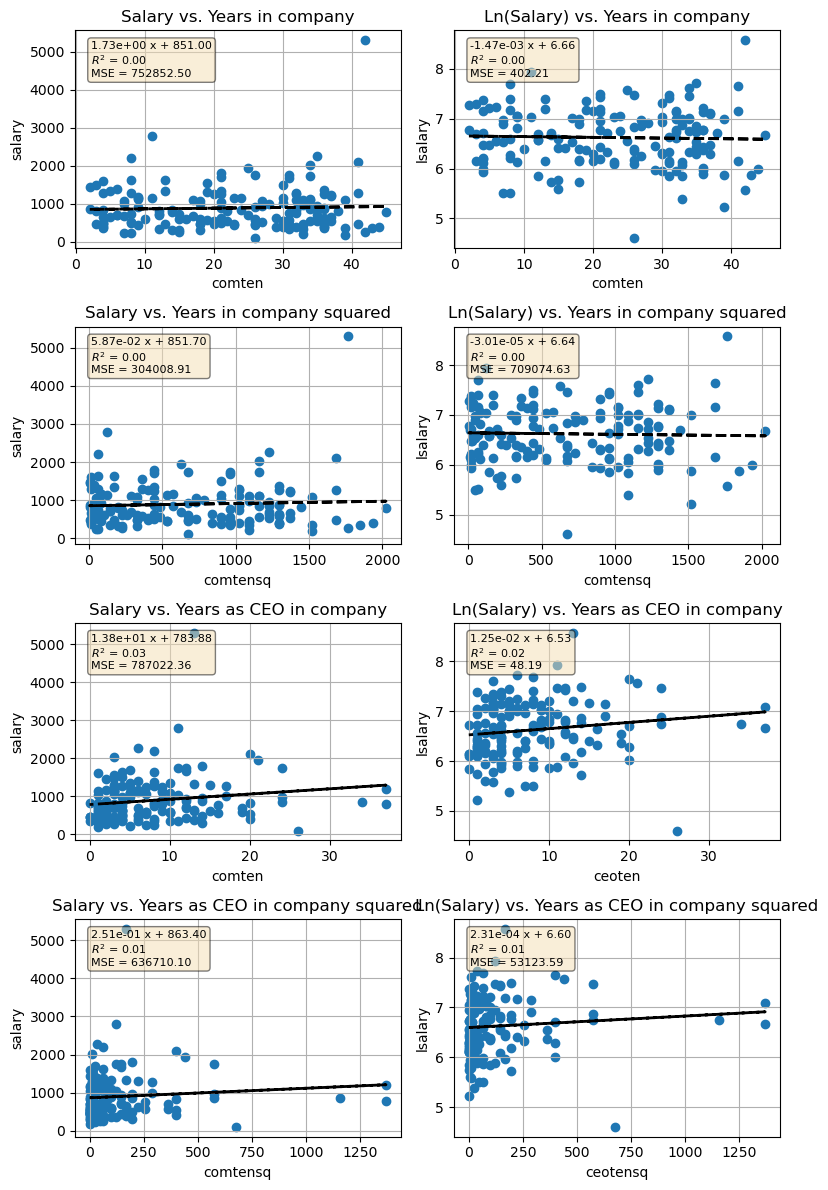

In [17]:
fig, axes = plt.subplots(4,2,figsize=(8,12),tight_layout=True)

ax = axes[0][0]
ax.set_title('Salary vs. Years in company')
x = df[['comten']]
y = df.salary
reg = LinearRegression().fit(x,y)
ax.set_ylabel('salary')
ax.set_xlabel('comten')
ax.scatter(x,y)
ax.plot(x,reg.predict(x),color='black',linestyle='--',linewidth=2)
textstr = '\n'.join((
    f'{reg.coef_[0]:.2e} x + {reg.intercept_:.2f}',
    f'$R^2$ = {reg.score(x, y):.2f}',
    f'MSE = {mse_score(x,reg.predict(x)):.2f}'
    ))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
ax.grid(True)

ax = axes[0][1]
ax.set_title('Ln(Salary) vs. Years in company')
x = df[['comten']]
y = df.lsalary
reg = LinearRegression().fit(x,y)
ax.set_ylabel('lsalary')
ax.set_xlabel('comten')
ax.scatter(x,y)
ax.plot(x,reg.predict(x),color='black',linestyle='--',linewidth=2)
textstr = '\n'.join((
    f'{reg.coef_[0]:.2e} x + {reg.intercept_:.2f}',
    f'$R^2$ = {reg.score(x, y):.2f}',
    f'MSE = {mse_score(x,reg.predict(x)):.2f}'
    ))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
ax.grid(True)

ax = axes[1][0]
ax.set_title('Salary vs. Years in company squared')
x = df[['comtensq']]
y = df.salary
reg = LinearRegression().fit(x,y)
ax.set_ylabel('salary')
ax.set_xlabel('comtensq')
ax.scatter(x,y)
ax.plot(x,reg.predict(x),color='black',linestyle='--',linewidth=2)
textstr = '\n'.join((
    f'{reg.coef_[0]:.2e} x + {reg.intercept_:.2f}',
    f'$R^2$ = {reg.score(x, y):.2f}',
    f'MSE = {mse_score(x,reg.predict(x)):.2f}'
    ))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
ax.grid(True)

ax = axes[1][1]
ax.set_title('Ln(Salary) vs. Years in company squared')
x = df[['comtensq']]
y = df.lsalary
reg = LinearRegression().fit(x,y)
ax.set_ylabel('lsalary')
ax.set_xlabel('comtensq')
ax.scatter(x,y)
ax.plot(x,reg.predict(x),color='black',linestyle='--',linewidth=2)
textstr = '\n'.join((
    f'{reg.coef_[0]:.2e} x + {reg.intercept_:.2f}',
    f'$R^2$ = {reg.score(x, y):.2f}',
    f'MSE = {mse_score(x,reg.predict(x)):.2f}'
    ))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
ax.grid(True)

ax = axes[2][0]
ax.set_title('Salary vs. Years as CEO in company')
x = df[['ceoten']]
y = df.salary
reg = LinearRegression().fit(x,y)
ax.set_ylabel('salary')
ax.set_xlabel('comten')
ax.scatter(x,y)
ax.plot(x,reg.predict(x),color='black',linestyle='--',linewidth=2)
textstr = '\n'.join((
    f'{reg.coef_[0]:.2e} x + {reg.intercept_:.2f}',
    f'$R^2$ = {reg.score(x, y):.2f}',
    f'MSE = {mse_score(x,reg.predict(x)):.2f}'
    ))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
ax.grid(True)


ax = axes[2][1]
ax.set_title('Ln(Salary) vs. Years as CEO in company')
x = df[['ceoten']]
y = df.lsalary
reg = LinearRegression().fit(x,y)
ax.set_ylabel('lsalary')
ax.set_xlabel('ceoten')
ax.scatter(x,y)
ax.plot(x,reg.predict(x),color='black',linestyle='--',linewidth=2)
textstr = '\n'.join((
    f'{reg.coef_[0]:.2e} x + {reg.intercept_:.2f}',
    f'$R^2$ = {reg.score(x, y):.2f}',
    f'MSE = {mse_score(x,reg.predict(x)):.2f}'
    ))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
ax.grid(True)

ax = axes[3][0]
ax.set_title('Salary vs. Years as CEO in company squared')
x = df[['ceotensq']]
y = df.salary
reg = LinearRegression().fit(x,y)
ax.set_ylabel('salary')
ax.set_xlabel('comtensq')
ax.scatter(x,y)
ax.plot(x,reg.predict(x),color='black',linestyle='--',linewidth=2)
textstr = '\n'.join((
    f'{reg.coef_[0]:.2e} x + {reg.intercept_:.2f}',
    f'$R^2$ = {reg.score(x, y):.2f}',
    f'MSE = {mse_score(x,reg.predict(x)):.2f}'
    ))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
ax.grid(True)


ax = axes[3][1]
ax.set_title('Ln(Salary) vs. Years as CEO in company squared')
x = df[['ceotensq']]
y = df.lsalary
reg = LinearRegression().fit(x,y)
ax.set_ylabel('lsalary')
ax.set_xlabel('ceotensq')
ax.scatter(x,y)
ax.plot(x,reg.predict(x),color='black',linestyle='--',linewidth=2)
textstr = '\n'.join((
    f'{reg.coef_[0]:.2e} x + {reg.intercept_:.2f}',
    f'$R^2$ = {reg.score(x, y):.2f}',
    f'MSE = {mse_score(x,reg.predict(x)):.2f}'
    ))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
ax.grid(True)


- Debido a que las variables _college_ y _grad_ son variables categóricas, se puede hacer un boxplot para analizar la diferencia entre estas condiciones respecto al salario:
    - En el primer boxplot se muestra que el salario no tiene una diferencia significativa si el CEO fue a la universidad o no, pero la cantida de CEOs que no fue a la universidad es demasiado baja (4 de 158) para afirmarlo a partir de tan pocos datos.
    - El segundo boxplot muestra que el salario entre los que se graduaron de la universidad o no, no es un factor estadísticamente significativo para mostrar cambios en el salario entre los dos grupos

Cantidad de CEOs que no fueron a la universidad 4 / 161
Cantidad de CEOs que se graduaron 75 / 161


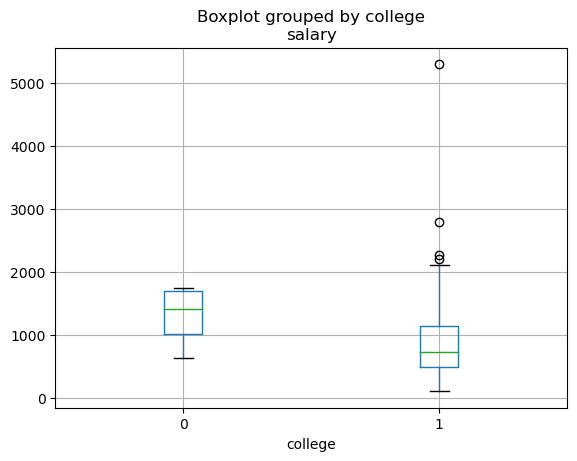

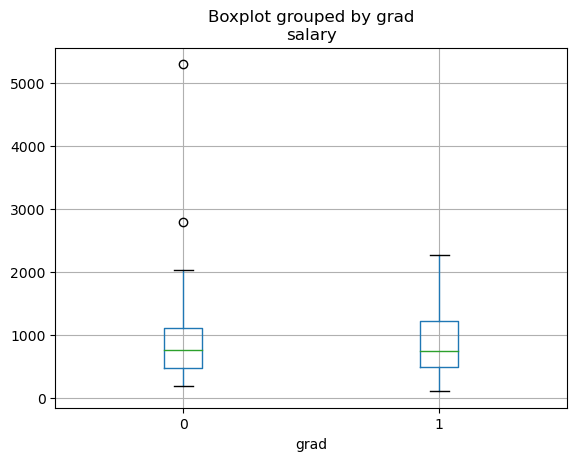

In [18]:
df.boxplot(column='salary',by='college')
print(f'Cantidad de CEOs que no fueron a la universidad {len(df[df["college"]==0])} / {len(df)}')
df.boxplot(column='salary',by='grad')
print(f'Cantidad de CEOs que se graduaron {len(df[df["grad"]==0])} / {len(df)}')

# Modelling

#### Selección de variables para el modelo

- Para seleccionar variables para el modelo se podría hacer la combinatoria entera de la cantidad de columnas, pero esto requeriría generar 16383 modelos (lo que aumenta mientras más variables se agreguen). Como los tiempos de ejecución del modelo estan en el orden de los ~10 segundos (para un modelo de GridSearchCV) esto implicaría varios días de exploración.
- Es por ello que en base al EDA se han seleccionado algunas alternativas de combinaciones de parametros o variables explicativas para comparar un máximo de 5 combinaciones de parámetros para cada modelo.
    - Naive: utilizar todas las columnas (excepto _lsalary_)
    - BestR2: Se utilizan solo las variables lineales que más correlación mostraron en el EDA anterior
    - BestR2Ln: Se utilizan solo las variables que más correlación mostraron en el EDA anterior, pero en su versión escalada logarítmicamente
    - WorstR2: Se utilizan las variables que menos correlación mostraron en el EDA anterior, se espera ver que los modelos con estas variables sean relativamente malos
    - BestR2-and-bias: Se utilizan variables con buena correlación, pero se agregan variables con menos correlación que por parcialidad del autor deberían tener influencia sobre el salario de un CEO.

In [19]:
manual_model_cols = list(df.columns)
manual_model_cols.remove('salary')
all_params = []
for comb_idx in range(len(manual_model_cols)+1):
    all_params.extend(list(itertools.combinations(manual_model_cols,comb_idx+1)))

all_comb_params = [list(elem) for elem in all_params]
print(len(all_comb_params))

16383


In [20]:
comb_params = []
model_alias = ['Naive','BestR2','BestR2Ln','WorstR2','BestR2-and-bias']
# Naive
comb_params.append(['age', 'college', 'grad', 'comten', 'ceoten', 'sales','profits', 
                    'mktval', 'lsales', 'lmktval', 'comtensq','ceotensq', 'profmarg']) 
# BestR2
comb_params.append(['sales','profits','mktval','profmarg'])
# BestR2Ln
comb_params.append(['lsales','profits','lmktval','profmarg'])
# Worst R^2
comb_params.append(['age', 'college', 'grad', 'comten', 'ceoten'])
# BestR2-and-bias
comb_params.append(['college', 'grad','ceoten','lsales','lmktval','profmarg'])

df_comp_models = pd.DataFrame({ 'model_alias':model_alias,
                                'cols_used':comb_params})

df_comp_models.head()

,model_alias,cols_used
0,Naive,"[age, college, grad, comten, ceoten, sales, pr..."
1,BestR2,"[sales, profits, mktval, profmarg]"
2,BestR2Ln,"[lsales, profits, lmktval, profmarg]"
3,WorstR2,"[age, college, grad, comten, ceoten]"
4,BestR2-and-bias,"[college, grad, ceoten, lsales, lmktval, profm..."


## Scaling

- Se aplica un scaling a cada columna por sí misma, excepto a las columnas logarítmicas (_lsalary_, _lmktval_, _lsales_) y elevadas al cuadrado (_comtensq_, _ceoten_), ya que estas columnas son un escalamiento de las originales.
- No se aplica scaling a los parámetros _grad_ y _college_ ya que son columnas categóricas

In [21]:
df_scaled = df.copy()

# Scale everything except Log and squared columns
for col in ['salary','age','comten','ceoten','sales','profits','mktval']:
    df_scaled[col] = StandardScaler().fit_transform(df_scaled[[col]])

In [22]:
df_scaled.head()

,salary,age,college,grad,comten,ceoten,sales,profits,mktval,lsalary,lsales,lmktval,comtensq,ceotensq,profmarg
0,0.459672,-0.955632,1,1,-1.158166,-0.823144,0.389901,1.791774,2.897906,7.057037,8.732305,10.051908,81,4,15.580645
1,-0.493275,-1.754887,1,1,-1.074021,0.329258,-0.551523,-0.450967,-0.410039,6.396930,5.645447,7.003065,100,100,16.961131
4,-0.668237,-1.621678,1,1,-1.242311,-0.246943,-0.540704,-0.499829,-0.516761,6.208590,5.860786,5.958425,64,36,7.977208
5,0.299998,1.042507,1,1,-1.326456,-0.102893,2.426446,0.931813,0.009067,6.972606,9.852194,8.268732,49,49,3.231579
6,0.092761,0.376461,1,0,1.029597,0.329258,-0.511270,-0.509601,-0.481437,6.851185,6.284134,6.434547,1225,100,4.477612


## TTSplit

- Se realiza un Train Test Split para evaluar los modelos

In [23]:
X = df_scaled.drop(["salary"], axis=1)
y = df_scaled["salary"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(128, 14)
(33, 14)
(128,)
(33,)


### OLS, Lasso & Ridge
- Cada modelo propuesto de las 5 alternativas propuestas se prueba con los tres métodos de regresión lineal
- Ordinary Least Squares (OLS): Este método será consistente cuando los regresores sean exógenos y no haya perfecta multicolinealidad, este será óptimo en la clase de parámetros lineales cuando los errores sean homocedásticos (es decir, que la varianza del error condicional a las variables explicativas es constante a lo largo de las observaciones) y además no haya autocorrelación.
- Ridge: Para reducir el overfitting, Rigde reduce los coeficientes de cada feature logrando que el modelo generalice mejor. Ridge funciona mejor cuando la mayoría de los atributos son relevantes, es decir,  las features están altamente correlacionadas.
- Lasso: también se busca regularizar para evitar el overfitting, pero en este caso, además de
empujar los valores para que estén cerca del 0, se hace que algunos coeficientes sean exactamente nulos. Esto hace que algunas features sean ignoradas por el modelo, por lo que Lasso es útil cuando sospechemos que varios de las features sean irrelevantes. 

In [24]:
%%time

r2_train = []
r2_adj_train = []
r2_test = []
r2_adj_test = []
mse_train = []
mse_test = []

for cols in df_comp_models['cols_used']:
    
    X = X_train[cols]
    y = y_train
    
    reg = LinearRegression().fit(X , y)
    
    r2 = reg.score(X, y)
    r2_adj = 1 - (1-r2)*(len(y)-1)/(len(y)-X.shape[1]-1)
    mse = mse_score(y, reg.predict(X))
    
    r2_train.append(r2)
    r2_adj_train.append(r2_adj)
    mse_train.append(mse)
    
    X = X_train[cols]
    y = y_train
    
    reg = LinearRegression().fit(X , y)
    r2 = reg.score(X, y)
    r2_adj = 1 - (1-r2)*(len(y)-1)/(len(y)-X.shape[1]-1)
    mse = mse_score(y, reg.predict(X))
    
    r2_test.append(r2)
    r2_adj_test.append(r2_adj)
    mse_test.append(mse)
    
df_comp_models['OLS_R2_train'] = r2_train
df_comp_models['OLS_R2_adj_train'] = r2_adj_train
df_comp_models['OLS_mse_train'] = mse_train

df_comp_models['OLS_R2_test'] = r2_test
df_comp_models['OLS_R2_adj_test'] = r2_adj_test
df_comp_models['OLS_mse_test'] = mse_test

CPU times: total: 375 ms
Wall time: 52 ms


In [25]:
%%time

r2_train = []
r2_adj_train = []
r2_test = []
r2_adj_test = []
mse_train = []
mse_test = []

for cols in df_comp_models['cols_used']:
    
    X = X_train[cols]
    y = y_train
    
    reg = Lasso(alpha=1.0).fit(X , y)
    
    r2 = reg.score(X, y)
    r2_adj = 1 - (1-r2)*(len(y)-1)/(len(y)-X.shape[1]-1)
    mse = mse_score(y, reg.predict(X))
    
    r2_train.append(r2)
    r2_adj_train.append(r2_adj)
    mse_train.append(mse)
    
    X = X_test[cols]
    y = y_test
    
    reg = Lasso(alpha=1.0).fit(X , y)
    r2 = reg.score(X, y)
    r2_adj = 1 - (1-r2)*(len(y)-1)/(len(y)-X.shape[1]-1)
    mse = mse_score(y, reg.predict(X))
    
    r2_test.append(r2)
    r2_adj_test.append(r2_adj)
    mse_test.append(mse)
    
df_comp_models['Lasso_R2_train'] = r2_train
df_comp_models['Lasso_R2_adj_train'] = r2_adj_train
df_comp_models['Lasso_mse_train'] = mse_train

df_comp_models['Lasso_R2_test'] = r2_test
df_comp_models['Lasso_R2_adj_test'] = r2_adj_test
df_comp_models['Lasso_mse_test'] = mse_test

CPU times: total: 359 ms
Wall time: 49 ms


In [26]:
%%time

r2_train = []
r2_adj_train = []
r2_test = []
r2_adj_test = []
mse_train = []
mse_test = []

for cols in df_comp_models['cols_used']:
    
    X = X_train[cols]
    y = y_train
    
    reg = Ridge(alpha=1.0).fit(X , y)
    
    r2 = reg.score(X, y)
    r2_adj = 1 - (1-r2)*(len(y)-1)/(len(y)-X.shape[1]-1)
    mse = mse_score(y, reg.predict(X))
    
    r2_train.append(r2)
    r2_adj_train.append(r2_adj)
    mse_train.append(mse)
    
    X = X_test[cols]
    y = y_test
    
    reg = Ridge(alpha=1.0).fit(X , y)
    r2 = reg.score(X, y)
    r2_adj = 1 - (1-r2)*(len(y)-1)/(len(y)-X.shape[1]-1)
    mse = mse_score(y, reg.predict(X))
    
    r2_test.append(r2)
    r2_adj_test.append(r2_adj)
    mse_test.append(mse_train)
    
df_comp_models['Ridge_R2_train'] = r2_train
df_comp_models['Ridge_R2_adj_train'] = r2_adj_train
df_comp_models['Ridge_mse_train'] = mse_train

df_comp_models['Ridge_R2_test'] = r2_test
df_comp_models['Ridge_R2_adj_test'] = r2_adj_test
df_comp_models['Ridge_mse_test'] = mse_test

CPU times: total: 375 ms
Wall time: 52.5 ms


In [27]:


class SelectColumns(BaseEstimator, TransformerMixin):
    def __init__(self, names=None):
        self.names = names

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X):
        return X[self.names]

In [28]:
%%time

est = DecisionTreeRegressor(random_state=0)
est.get_params().keys()

parameters = {
    'model__max_depth': np.arange(2,10),
    'model__min_samples_split': np.arange(2,10),
    'model__min_samples_leaf': np.arange(1,5)
}

r2_train = []
r2_adj_train = []
r2_test = []
r2_adj_test = []
mse_train = []
mse_test = []
gs_cv_best_params = []

for cols in df_comp_models['cols_used']:

    pipe = Pipeline([
        ("features", FeatureUnion([
            ('numeric', make_pipeline(SelectColumns(names=cols),StandardScaler())),
            #('numeric', make_pipeline(SelectColumns(names=cols))),
        ])),
        ('model', DecisionTreeRegressor(random_state=0,criterion='squared_error'))
    ])

    gridsearch = GridSearchCV(pipe,parameters, n_jobs=-1, cv=5)
    
    X = X_train[cols]
    y = y_train
    
    gridsearch.fit(X, y)
    
    r2 = gridsearch.score(X, y)
    r2_adj = 1 - (1-r2)*(len(y)-1)/(len(y)-X.shape[1]-1)
    mse = mse_score(y, gridsearch.predict(X))
    
    r2_train.append(r2)
    r2_adj_train.append(r2_adj)
    mse_train.append(mse)
    
    X = X_test[cols]
    y = y_test
    
    gridsearch.fit(X, y)
    
    
    gridsearch.fit(X, y)
    r2 = gridsearch.score(X, y)
    r2_adj = 1 - (1-r2)*(len(y)-1)/(len(y)-X.shape[1]-1)
    mse = mse_score(y, gridsearch.predict(X))
    
    r2_test.append(r2)
    r2_adj_test.append(r2_adj)
    mse_test.append(mse)
    
    gs_cv_best_params.append(gridsearch.best_params_)
    
df_comp_models['DTReg_R2_train'] = r2_train
df_comp_models['DTReg_R2_adj_train'] = r2_adj_train
df_comp_models['DTReg_mse_train'] = mse_train

df_comp_models['DTReg_R2_test'] = r2_test
df_comp_models['DTReg_R2_adj_test'] = r2_adj_test
df_comp_models['DTReg_mse_test'] = mse_test
df_comp_models['gs_cv_best_params'] = gs_cv_best_params

CPU times: total: 17.8 s
Wall time: 25.8 s


In [29]:
df_comp_models

,model_alias,cols_used,OLS_R2_train,OLS_R2_adj_train,OLS_mse_train,OLS_R2_test,OLS_R2_adj_test,OLS_mse_test,Lasso_R2_train,Lasso_R2_adj_train,...,Ridge_R2_test,Ridge_R2_adj_test,Ridge_mse_test,DTReg_R2_train,DTReg_R2_adj_train,DTReg_mse_train,DTReg_R2_test,DTReg_R2_adj_test,DTReg_mse_test,gs_cv_best_params
0,Naive,"[age, college, grad, comten, ceoten, sales, pr...",0.333408,0.257393,0.723050,0.333408,0.257393,0.723050,0.015908,-0.096313,...,0.777556,0.625358,"[0.7250767886981812, 0.8970094663513475, 0.873...",0.239265,0.152514,0.825167,0.831175,0.715663,0.110353,"{'model__max_depth': 2, 'model__min_samples_le..."
1,BestR2,"[sales, profits, mktval, profmarg]",0.173035,0.146142,0.897006,0.173035,0.146142,0.897006,0.000000,-0.032520,...,0.426295,0.344337,"[0.7250767886981812, 0.8970094663513475, 0.873...",0.221334,0.196011,0.844616,0.918631,0.907006,0.053187,"{'model__max_depth': 4, 'model__min_samples_le..."
2,BestR2Ln,"[lsales, profits, lmktval, profmarg]",0.195120,0.168945,0.873050,0.195120,0.168945,0.873050,0.000000,-0.032520,...,0.646163,0.595615,"[0.7250767886981812, 0.8970094663513475, 0.873...",0.221334,0.196011,0.844616,0.918631,0.907006,0.053187,"{'model__max_depth': 4, 'model__min_samples_le..."
3,WorstR2,"[age, college, grad, comten, ceoten]",0.061833,0.023383,1.017626,0.061833,0.023383,1.017626,0.000000,-0.040984,...,0.243004,0.102819,"[0.7250767886981812, 0.8970094663513475, 0.873...",0.160162,0.125742,0.910969,0.999100,0.998933,0.000588,"{'model__max_depth': 9, 'model__min_samples_le..."
4,BestR2-and-bias,"[college, grad, ceoten, lsales, lmktval, profm...",0.242247,0.204673,0.821931,0.242247,0.204673,0.821931,0.000000,-0.049587,...,0.663691,0.586081,"[0.7250767886981812, 0.8970094663513475, 0.873...",0.250834,0.213685,0.812617,0.794346,0.746887,0.134426,"{'model__max_depth': 2, 'model__min_samples_le..."


### Resultados
- Se muestran los coeficientes $R^2$ ajustados para cada modelo y para cada set de parámetros, tanto para los subdatasets de train y test, se puede obtener las siguientes conclusiones para los datasets de Train.
    - Con OLS el mejor R2 ajustado se obtiene para el modelo con más cantidad de parámetros (Naive), la desventaja de este tipo de modelos es que se pierde facilidad de interpretación en las interacciones de los parámetros como funciones explicativas del salario de los CEOs. Se puede ver que con solo 4 variables (las que mejor R2 habían dado en el EDA) se puede explicar un 16\% de las variaciones del salario de los CEOs, en lugar de las 13 utilizadas en naive.
    - El método de regresión Lasso tiene una performance muy pobre, independientemente del modelo que se utilice, se debe notar que no se optimizaron los hiperparámetros del regresor (alpha).
    - El método Ridge tiene una performance muy similar a OLS en todos los conjuntos de modelos.
    - El Decision Tree Regressor tiene una performance superior para todos los modelos que OLS o Ridge.
    - Como era de esperarse, todos los modelos de regresión tienen baja performance si se seleccionan las columnas menos explicativas, excepto el Decision Tree, lo que llevaría a pensar que esta haciendo overfitting
    
- Sobre el dataset de test, se pueden mencionar algunos aspectos:
    - Se puede confirmar que el Decision Tree está generando overfitting ya que tiene un R2 ajustado notablemente alto.
    - Se puede ver que la regresión de Ridge tiene una mejor performance en test, para los modelos con mejor R2 y con mejor R2 y las variables incluidas por parcialidad.

In [30]:
df_comp_models[['model_alias','cols_used',
                'OLS_R2_adj_train','Lasso_R2_adj_train','Ridge_R2_adj_train','DTReg_R2_adj_train']]

,model_alias,cols_used,OLS_R2_adj_train,Lasso_R2_adj_train,Ridge_R2_adj_train,DTReg_R2_adj_train
0,Naive,"[age, college, grad, comten, ceoten, sales, pr...",0.257393,-0.096313,0.255311,0.152514
1,BestR2,"[sales, profits, mktval, profmarg]",0.146142,-0.032520,0.146138,0.196011
2,BestR2Ln,"[lsales, profits, lmktval, profmarg]",0.168945,-0.032520,0.168931,0.196011
3,WorstR2,"[age, college, grad, comten, ceoten]",0.023383,-0.040984,0.023335,0.125742
4,BestR2-and-bias,"[college, grad, ceoten, lsales, lmktval, profm...",0.204673,-0.049587,0.204239,0.213685


In [31]:
df_comp_models[['model_alias','cols_used',
                'OLS_R2_adj_test','Lasso_R2_adj_test','Ridge_R2_adj_test','DTReg_R2_adj_test']]

,model_alias,cols_used,OLS_R2_adj_test,Lasso_R2_adj_test,Ridge_R2_adj_test,DTReg_R2_adj_test
0,Naive,"[age, college, grad, comten, ceoten, sales, pr...",0.257393,-0.608463,0.625358,0.715663
1,BestR2,"[sales, profits, mktval, profmarg]",0.146142,-0.142857,0.344337,0.907006
2,BestR2Ln,"[lsales, profits, lmktval, profmarg]",0.168945,-0.142857,0.595615,0.907006
3,WorstR2,"[age, college, grad, comten, ceoten]",0.023383,-0.185185,0.102819,0.998933
4,BestR2-and-bias,"[college, grad, ceoten, lsales, lmktval, profm...",0.204673,-0.230769,0.586081,0.746887


# Statsmodel Summary para Ridge

- Para generar un summary con Ridge se utilizó la solución propuesta en https://stackoverflow.com/questions/40072870/statistical-summary-table-in-sklearn-linear-model-ridge
- Se genera el summary del modelo *BestR2Ln* para la regresión de Ridge
- Se puede ver que el R2 ajustado con Statsmodel para todos los datos es de 0.223. El R2 es cercano al ajustado porque se estan utilizando pocas variables y todas tienen un peso importante en la explicación de la variación de la variable dependiente. Este R2 ajustado es más cercano al obtenido con el dataset de train que de test, y esto se puede explicar porque el dataset de train contiene el 80\% de los datos.
- Los coeficientes de cada variable indican que hay una dependencia lineal directa con el logaritmo de las ventas y el logaritmo de market value, mientras que hay una dependencia lineal inversa con el margen de ganancia (profmarg).
- Analizando los p-value de las pruebas de chi-squared de significancia, se encuentra que estos valores son demasiado altos, confirmando la hipótesis nula (es decir, que las variables no esten relacionadas linealmente). El único pvalue aceptable es el de lmktval, que está por debajo del 5\%. repite el análisis de regresión únicamente con ese parámetro.
- Repitiendo el análisis de regresión únicamente con lmktval y con OLS como variable independiente (no es necesario Ridge ya que estamos analizando una sola variable) se encuentra que el R2 ajustado es muy similar al modelo anterior con más variables, y el valor de significancia es suficientemente chico como para asegurar que las variables están relacionadas linealmente entre sí

In [32]:
def regression_analysis(X, y, model):
    
    is_statsmodels = False
    is_sklearn = False
    
    # check for accepted linear models
    if type(model) in [sklearn.linear_model._base.LinearRegression,
                       sklearn.linear_model._ridge.Ridge,
                       sklearn.linear_model._ridge.RidgeCV,
                       sklearn.linear_model._coordinate_descent.Lasso,
                       sklearn.linear_model._coordinate_descent.LassoCV,
                       sklearn.linear_model._coordinate_descent.ElasticNet,
                       sklearn.linear_model._coordinate_descent.ElasticNetCV,
                      ]:
        is_sklearn = True
    elif type(model) in [statsmodels.regression.linear_model.OLS, 
                         statsmodels.base.elastic_net.RegularizedResults,
                        ]:
        is_statsmodels = True
    else:
        print("Only linear models are supported!")
        return None
    
    
    
    has_intercept = False
    
    if is_statsmodels and all(np.array(X)[:,0]==1):
        # statsmodels add_constant has been used already
        has_intercept = True  
    elif is_sklearn and model.intercept_:
        has_intercept = True
        

    
    if is_statsmodels:
        # add_constant has been used already
        x = X
        model_params = model.params
    else: # sklearn model
        if has_intercept:
            x = sm.add_constant(X)
            model_params = np.hstack([np.array([model.intercept_]), model.coef_])
        else:
            x = X
            model_params = model.coef_
        
    #y = np.array(y).ravel()
    
    # define the OLS model
    olsModel = sm.OLS(y, x)
    
    pinv_wexog,_ = pinv_extended(x)
    normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
    
    
    return sm.regression.linear_model.OLSResults(olsModel, model_params, normalized_cov_params)
    

In [33]:
list(df_comp_models[df_comp_models['model_alias'] == 'BestR2Ln']['cols_used'])[0]

['lsales', 'profits', 'lmktval', 'profmarg']

In [34]:
skridge = Ridge(alpha=0.0, max_iter=9000, tol=1e-5, fit_intercept=True)

cols = list(df_comp_models[df_comp_models['model_alias'] == 'BestR2Ln']['cols_used'])[0]
X = df[cols]
y = df['salary']
skridge.fit(X,y)

result = regression_analysis(X, y, skridge)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     12.48
Date:                Mon, 09 Oct 2023   Prob (F-statistic):           7.82e-09
Time:                        21:59:49   Log-Likelihood:                -1232.9
No. Observations:                 161   AIC:                             2476.
Df Residuals:                     156   BIC:                             2491.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -471.8147    444.924     -1.060      0.291   -1350.667     407.038
lsales        14.6897     83.402      0.176      0.860    -150.054     179.433
profits        0.1953      0.169      1.156      0.249      -0.138       0.529
lmktval      179.9017     88.111      2.042      0.043       5.858     353.946
profmarg     -17.5737     15.038     -1.169      0.244     -47.277      12.130
==============================================================================
Omnibus:                      188.603   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7918.406
Skew:                           4.390   Prob(JB):                         0.00
Kurtosis:                      36.216   Cond. No.                     5.13e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
skridge = Ridge(alpha=0.0, max_iter=9000, tol=1e-5, fit_intercept=True)

cols = ['lmktval','lsales']
X = df[cols]
y = df['salary']
skridge.fit(X,y)

result = regression_analysis(X, y, skridge)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     23.89
Date:                Mon, 09 Oct 2023   Prob (F-statistic):           8.60e-10
Time:                        21:59:50   Log-Likelihood:                -1234.0
No. Observations:                 161   AIC:                             2474.
Df Residuals:                     158   BIC:                             2483.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -944.7736    271.233     -3.483      0.001   -1480.483    -409.064
lmktval      148.4841     55.739      2.664      0.009      38.395     258.573
lsales        98.7517     49.018      2.015      0.046       1.936     195.567
==============================================================================
Omnibus:                      184.665   Durbin-Watson:                   2.113
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7347.848
Skew:                           4.258   Prob(JB):                         0.00
Kurtosis:                      34.981   Cond. No.                         70.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
result = regression_analysis(X, y, skridge)
result.summary()
formula = 'salary ~ lmktval'
lm = sm.formula.ols(formula=formula, data=df).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     42.90
Date:                Mon, 09 Oct 2023   Prob (F-statistic):           7.59e-10
Time:                        21:59:50   Log-Likelihood:                -1236.1
No. Observations:                 161   AIC:                             2476.
Df Residuals:                     159   BIC:                             2482.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -861.0678    270.597     -3.182      0.0

### Conclusiones

- Se concluye que un modelo de regresión de OLS se obtiene una explicación sumamente simple de aproximadamente un 20\% de las causas de la variación del salario de un CEO, con un nivel de significancia alto ($p<0.002$). A partir de los datos y en análisis realizado se puede decir que al menos un 20\% de las variaciones del salario de un CEO siguen la función lineal:

$salary \approx 235 \cdot Ln(MktVal)-861$ 